# Imports

In [34]:
import optuna
import mlflow
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold

optuna.logging.set_verbosity(optuna.logging.WARNING)

# Gerando as funções de treinamento

In [2]:
def remove_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.select_dtypes(exclude='number').columns
    for cols in cols:
        df[cols] = df[cols].astype('category').cat.codes
    return df

In [3]:
def train_linear_regression(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"LINEAR REGRESSION: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    LinearRegressionParams = {
        "fit_intercept": [True, False],
        "copy_X": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in LinearRegressionParams.items()}

        with mlflow.start_run():
            model = LinearRegression(**model_params, n_jobs=-1)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/LinearRegressionParams_{test_name}_study.csv')

In [4]:
def train_ridge(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RIDGE: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RidgeRegressionParams = {
        "alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
        "fit_intercept": [True, False],
        "copy_X": [True, False],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RidgeRegressionParams.items()}

        with mlflow.start_run():
            model = Ridge(**model_params, random_state=42, positive=False)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')

            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/Ridge_{test_name}_study.csv')

In [5]:
def train_SVR(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"SVR: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    SVRParams = {
        "C": [0.01, 0.1, 1, 10, 100],
        "kernel": ["linear", "rbf"],
        "degree": [2, 3, 5],
        "gamma": ["scale", "auto"],
        "coef0": [0.0, 0.5, 1.0, 5.0]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in SVRParams.items()}

        with mlflow.start_run():
            # Limitando pois é um treinamento demorado
            model = SVR(**model_params, max_iter=1000)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/SVR_{test_name}_study.csv')

In [6]:
def train_RandomForestRegressor(df_train: pd.DataFrame, df_val: pd.DataFrame, test_name: str) -> None:
    print(f"RANDOM FOREST: {test_name:^20}")

    df_train = remove_categorical_columns(df_train).dropna()
    df_val = remove_categorical_columns(df_val).dropna()

    X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
    X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

    RandomForestRegressorParams = {
        "n_estimators": [10, 50, 100, 200, 500],
        "criterion": ['absolute_error', 'squared_error', 'friedman_mse'],
        "max_depth": [None, 5, 10, 20, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    }

    def objective(trial):
        model_params = {key: trial.suggest_categorical(key, values) for key, values in RandomForestRegressorParams.items()}

        with mlflow.start_run():
            model = RandomForestRegressor(**model_params, n_jobs=-1, random_state=42)
            model.fit(X_train, y_train)

            # Fazer previsões e calcular o erro quadrático médio
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)

            # Registrar os parâmetros e métricas no MLflow
            for key, value in model_params.items():
                mlflow.log_param(key, value)

            mlflow.log_metric('mse', mse)
            mlflow.sklearn.log_model(model, 'model')
            return mse

    # Configurar e executar a otimização do Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print('Melhores hiperparâmetros:', study.best_params)
    print('Melhor valor objetivo:', study.best_value)

    study.trials_dataframe().to_csv(f'../data/RandomForestRegressor_{test_name}_study.csv')

# Treinando

In [7]:
datasets = [
    "df_preprocessed",
    "df_preprocessed_normalized",
    "df"
]

In [8]:
for dataset in datasets:
    for i in ["train", "val", "test"]:
        df = pd.read_csv(f"../data/{dataset}_{i}.csv")
        if i == "train":
            df_train = df
        elif i == "val":
            df_val = df
        else:
            df_test = df
    train_linear_regression(df_train, df_val, dataset)
    train_ridge(df_train, df_val, dataset)
    if "normalized" in dataset:
        train_SVR(df_train, df_val, dataset)
    train_RandomForestRegressor(df_train, df_val, dataset)

LINEAR REGRESSION:   df_preprocessed   


/opt/homebrew/Cellar/python@3.11/3.11.7_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Melhores hiperparâmetros: {'fit_intercept': False, 'copy_X': False}
Melhor valor objetivo: 4752737.142530321
RIDGE:   df_preprocessed   


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.27367e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.27367e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt

Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': True, 'copy_X': False, 'solver': 'svd'}
Melhor valor objetivo: 4752938.007250519
RANDOM FOREST:   df_preprocessed   
Melhores hiperparâmetros: {'n_estimators': 200, 'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Melhor valor objetivo: 421224.5297782511
LINEAR REGRESSION: df_preprocessed_normalized
Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
Melhor valor objetivo: 0.1142174982924279
RIDGE: df_preprocessed_normalized


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter 

Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': True, 'copy_X': True, 'solver': 'svd'}
Melhor valor objetivo: 0.11420992765267211
SVR: df_preprocessed_normalized


/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1

Melhores hiperparâmetros: {'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0}
Melhor valor objetivo: 0.04854253148412284
RANDOM FOREST: df_preprocessed_normalized
Melhores hiperparâmetros: {'n_estimators': 50, 'criterion': 'absolute_error', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Melhor valor objetivo: 0.01614020360164839
LINEAR REGRESSION:          df         
Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
Melhor valor objetivo: 1070991.7884971937
RIDGE:          df         


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.30156e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.4004e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/

Melhores hiperparâmetros: {'alpha': 10, 'fit_intercept': True, 'copy_X': False, 'solver': 'cholesky'}
Melhor valor objetivo: 1070846.4398777047
RANDOM FOREST:          df         
Melhores hiperparâmetros: {'n_estimators': 10, 'criterion': 'friedman_mse', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
Melhor valor objetivo: 198043.68385618663


Olhando as os melhores resultados dos modelos, em geral, pode-se descartar a solução não normalizada.
O melhor modelo de cada algorítmo foi:

 - Linear regression:
    - Melhores hiperparâmetros: {'fit_intercept': True, 'copy_X': True}
    - Melhor valor objetivo: 0.1142174982924279
 - Ridge:
    - Melhores hiperparâmetros: {'alpha': 0.001, 'fit_intercept': True, 'copy_X': True, 'solver': 'svd'}
    - Melhor valor objetivo: 0.11420992765267211
 - SVR:
    - Melhores hiperparâmetros: {'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0}
    - Melhor valor objetivo: 0.04854253148412284
 - Random Forest:
    - Melhores hiperparâmetros: {'n_estimators': 50, 'criterion': 'absolute_error', 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}
    - Melhor valor objetivo: 0.01614020360164839

# Scatter plot com clustering

In [7]:
df_train = pd.read_csv("../data/df_preprocessed_normalized_train.csv")
df_test = pd.read_csv("../data/df_preprocessed_normalized_test.csv")
df_val = pd.read_csv("../data/df_preprocessed_normalized_val.csv")

df_train = remove_categorical_columns(df_train).dropna()
df_test = remove_categorical_columns(df_test).dropna()
df_val = remove_categorical_columns(df_val).dropna()

In [8]:
len(df_train.columns)

22

In [36]:
df = df_train.copy()

In [46]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(df.drop(columns=["Next Week's Deaths"]))
df["cluster"] = clusters

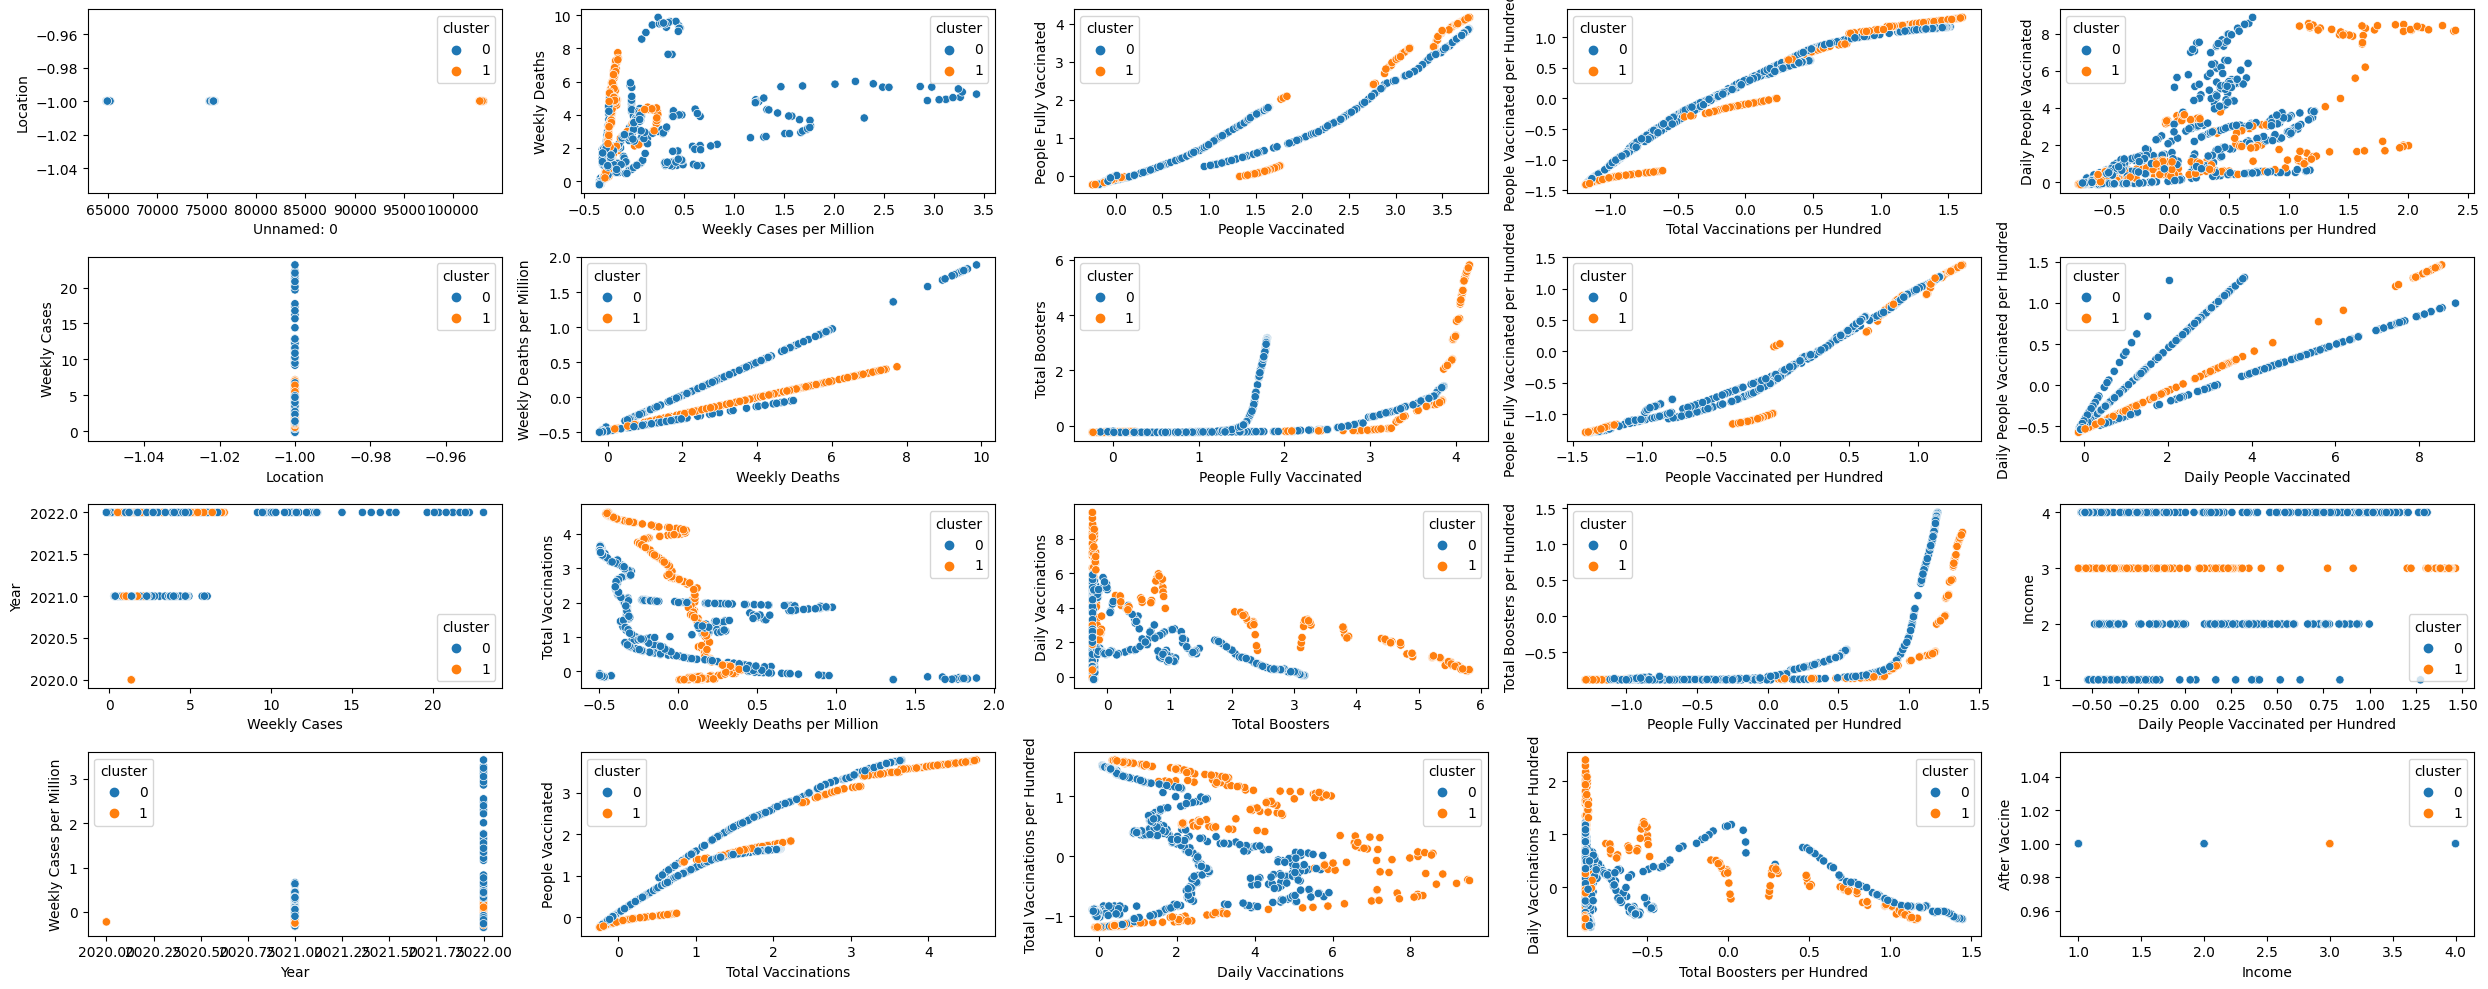

In [47]:
figs, axes = plt.subplots(4,5,figsize=(25,10))
i, j = 0, 0
cols = df_train.drop(columns=["Next Week's Deaths"]).columns
for idx in range(len(cols)-1):
    sns.scatterplot(data=df, x=cols[idx], y=cols[idx + 1], hue='cluster', ax=axes[i, j])
    i+=1
    if i == 4:
        i = 0
        j+=1
plt.tight_layout()

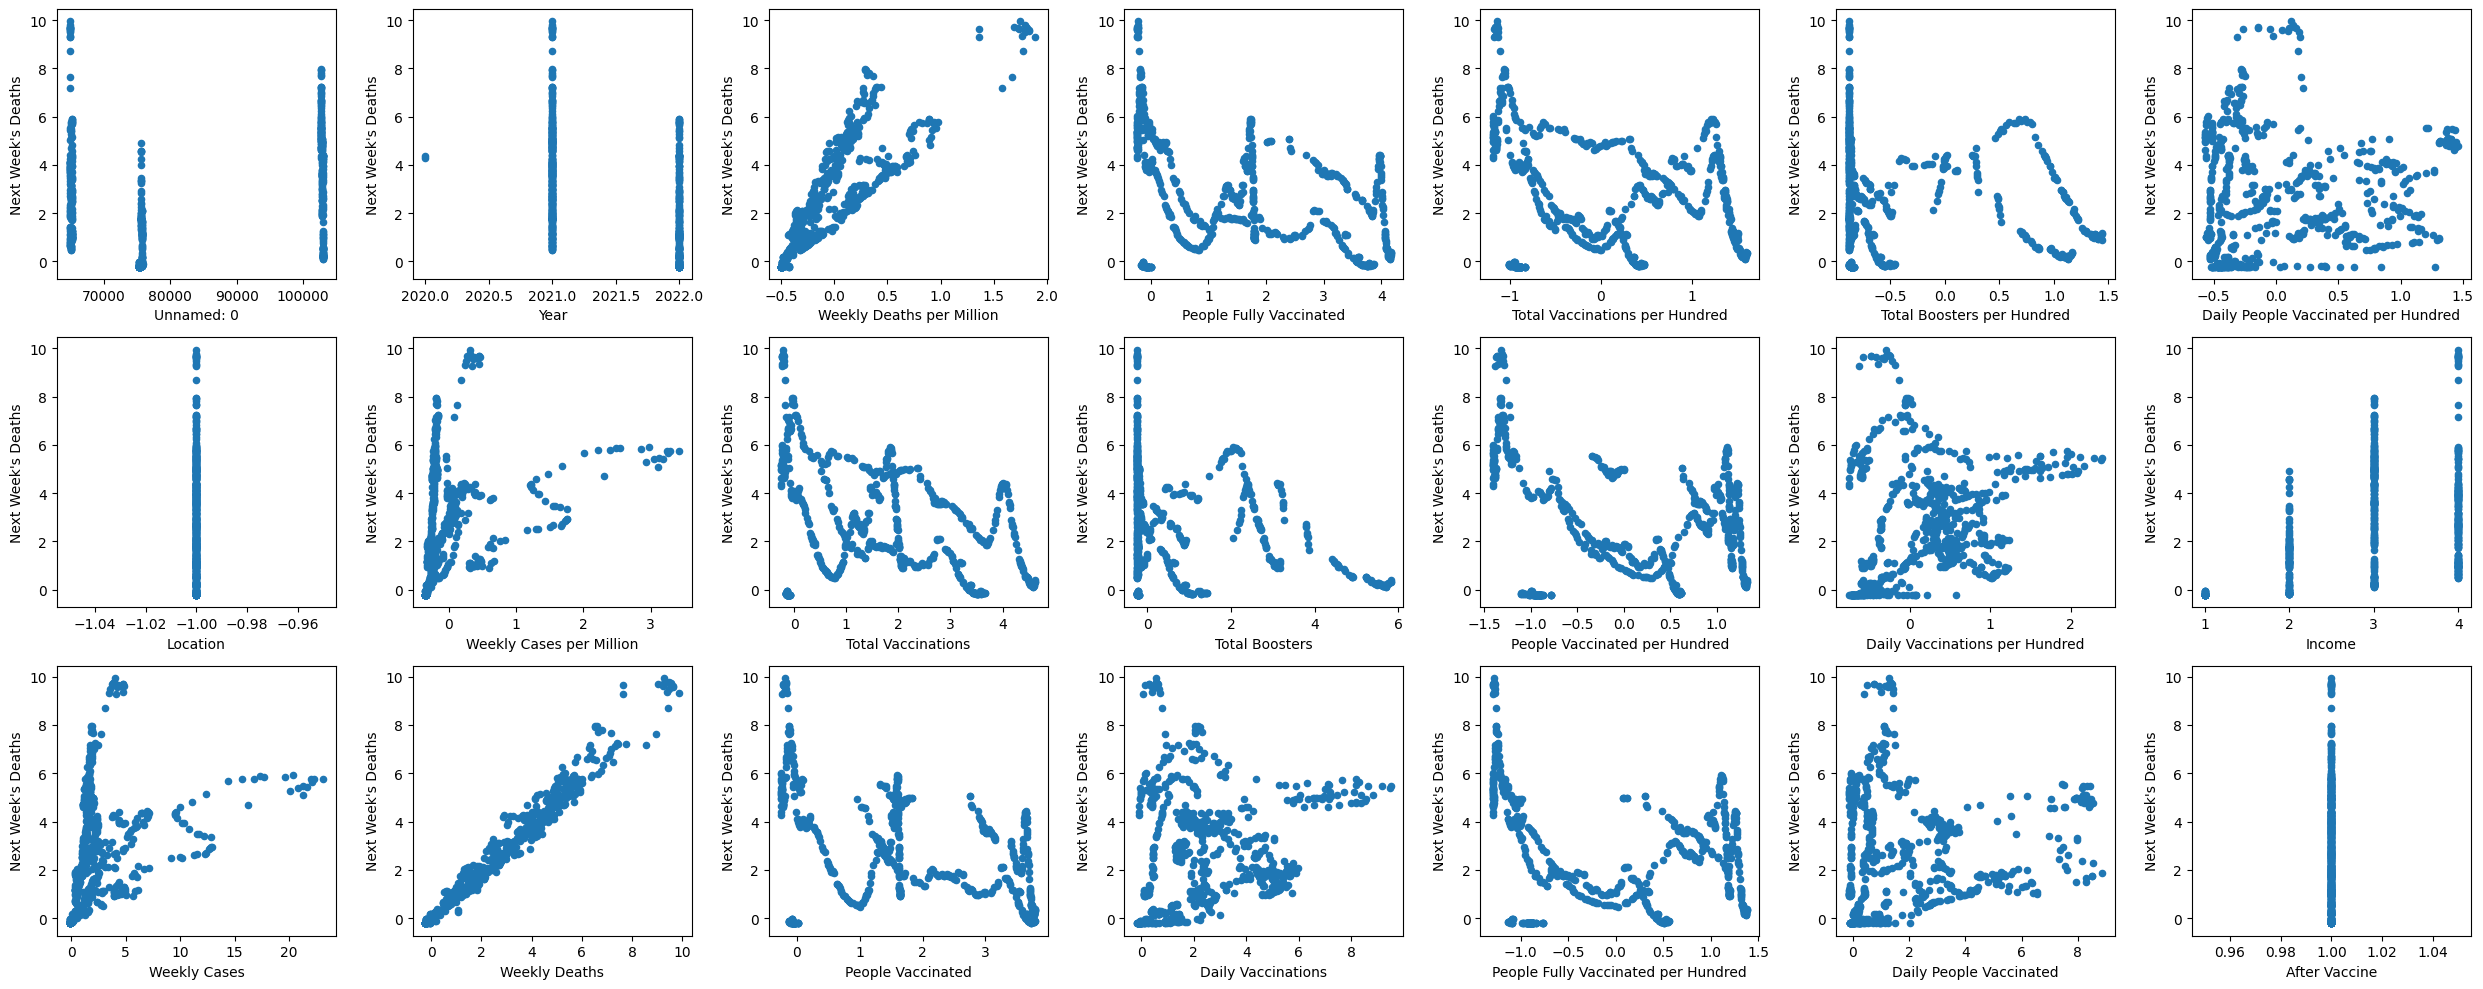

In [9]:
figs, axes = plt.subplots(3,7,figsize=(25,10))
i, j = 0, 0
for col in df_train.drop(columns=["Next Week's Deaths"]).columns:
    df_train[[col, "Next Week's Deaths"]].plot.scatter(x=col, y="Next Week's Deaths", ax=axes[i, j])
    i+=1
    if i == 3:
        i = 0
        j+=1
plt.tight_layout()

# Escolhendo o Melhor modelo pelo conjunto de teste

In [10]:
X_train, y_train = df_train.drop(columns=["Next Week's Deaths"]), df_train["Next Week's Deaths"]
X_test, y_test = df_test.drop(columns=["Next Week's Deaths"]), df_test["Next Week's Deaths"]
X_val, y_val = df_val.drop(columns=["Next Week's Deaths"]), df_val["Next Week's Deaths"]

### Linear Regression

In [11]:
lr_model = LinearRegression(**{'fit_intercept': True, 'copy_X': True}, n_jobs=-1)
lr_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = lr_model.predict(X_val)
lr_mse_val = mean_squared_error(y_val, y_pred)

y_pred = lr_model.predict(X_test)
lr_mse_test = mean_squared_error(y_test, y_pred)

lr_mse_val, lr_mse_test

(0.10834622013794715, 0.09308352840682599)

O erro no treinamento do Linear Regression foi de aproximadamente 10.83% e no conjunto de teste foi de 9.3%, o que sugere uma baixa variância mas um alto viés, o que significa que essa não é uma boa arquitetura para resolver esse problema.

### Ridge

In [12]:
ridge_model = Ridge(**{'alpha': 0.001, 'fit_intercept': True, 'copy_X': True, 'solver': 'svd'}, random_state=42)
ridge_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = ridge_model.predict(X_val)
ridge_mse_val = mean_squared_error(y_val, y_pred)

y_pred = ridge_model.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, y_pred)

ridge_mse_val, ridge_mse_test

(0.10833588599742265, 0.09307724632163433)

O erro no treinamento do Ridge foi de aproximadamente 10.83% e no conjunto de teste foi de 9.3%, o que sugere uma baixa variância mas um alto viés, o que significa que essa não é uma boa arquitetura para resolver esse problema.

### SVR

In [13]:
svr_model = SVR(**{'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0})
svr_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = svr_model.predict(X_val)
svr_mse_val = mean_squared_error(y_val, y_pred)

y_pred = svr_model.predict(X_test)
svr_mse_test = mean_squared_error(y_test, y_pred)

svr_mse_val, svr_mse_test

(0.006503892538418461, 0.015011603647737489)

O erro no treinamento do SVR foi de aproximadamente 0.65% e no conjunto de teste foi de 1.5%, o que sugere uma baixa variância mas um baixo viés, o que significa que essa é uma boa arquitetura para resolver esse problema.

### Random Forest

In [25]:
rf_model = RandomForestRegressor(**{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}, random_state=42, n_jobs=-1)
rf_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]))
y_pred = rf_model.predict(X_val)
rf_mse_val = mean_squared_error(y_val, y_pred)

y_pred = rf_model.predict(X_test)
rf_mse_test = mean_squared_error(y_test, y_pred)

rf_mse_val, rf_mse_test

(0.0010523298467533472, 0.014730718738492302)

O erro no treinamento do Random Forest foi de aproximadamente 0.10% e no conjunto de teste foi de 1.4%, o que sugere uma baixa variância mas um baixo viés, o que significa que essa é uma boa arquitetura para resolver esse problema.

Tanto o Random Forest quanto o SVR possuem boas perfomances e podem resolver o problema, abaixo está uma comparação mais detalhada para decidirmos qual modelo será deployado.

# Cross validation

In [30]:
def collect_errors(model, X, y, X_test, y_test):
    errors_val, errors_test = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        errors_val.append(mse)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        errors_test.append(mse)

    return errors_val, errors_test

In [31]:
rf_model = RandomForestRegressor(**{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}, random_state=42, n_jobs=-1)
svr_model = SVR(**{'C': 10, 'kernel': 'rbf', 'degree': 2, 'gamma': 'auto', 'coef0': 0.0})

svr_errors_val, svr_errors_test = collect_errors(svr_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)
rf_errors_val, rf_errors_test = collect_errors(rf_model, np.concatenate([X_train, X_val]), np.concatenate([y_train,y_val]), X_test, y_test)

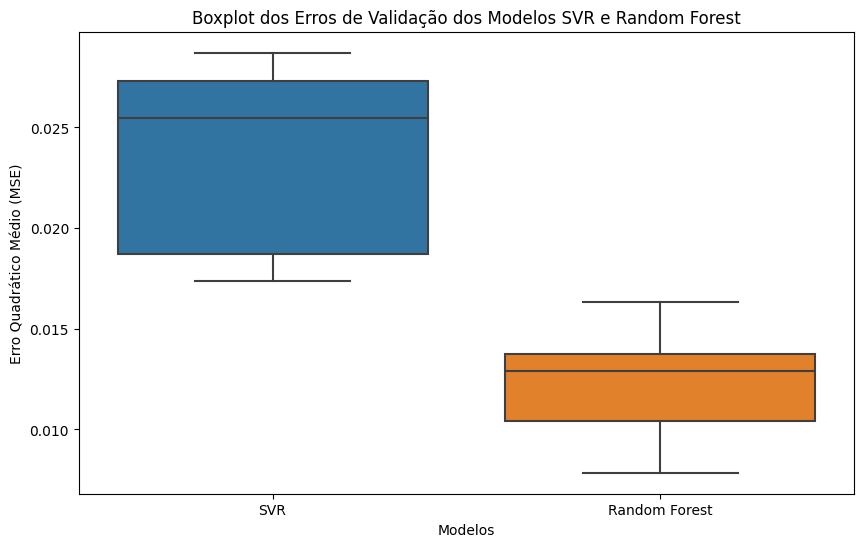

In [32]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_val,
    'Random Forest': rf_errors_val
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de Validação dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

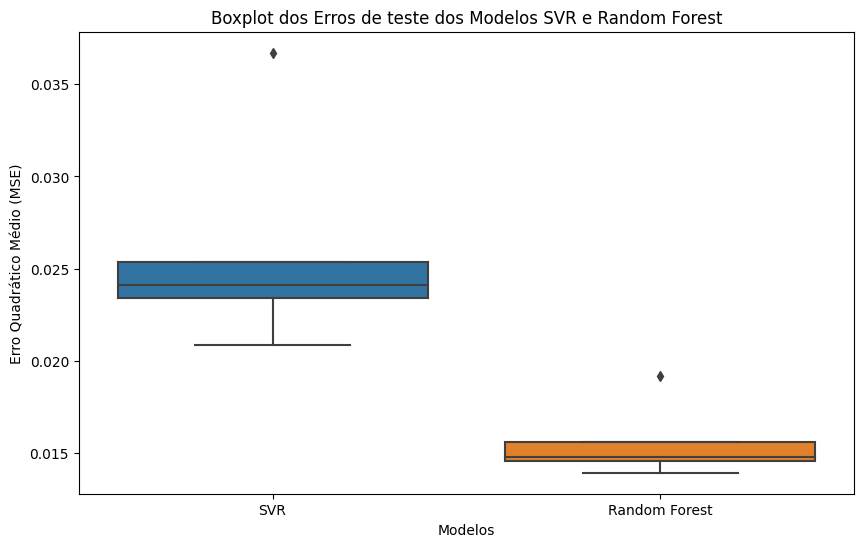

In [33]:
errors_df = pd.DataFrame({
    'SVR': svr_errors_test,
    'Random Forest': rf_errors_test
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=errors_df)
plt.title('Boxplot dos Erros de teste dos Modelos SVR e Random Forest')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.xlabel('Modelos')
plt.show()

Assim, nota-se que o Random Forest é o melhor modelo.